In [48]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models, regularizers
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [4]:
train_directory = "./DATASET/train"
test_directory = "./DATASET/test"
CLASS_NAMES = ["1", "2", "3", "4", "5", "6", "7"]

In [5]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',   
    batch_size=32,
    image_size=(100, 100),
    shuffle=True,
    seed=99,
)

Found 12271 files belonging to 7 classes.


In [6]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=32,
    image_size=(100, 100),
    shuffle=True,
    seed=99,
)

Found 3068 files belonging to 7 classes.


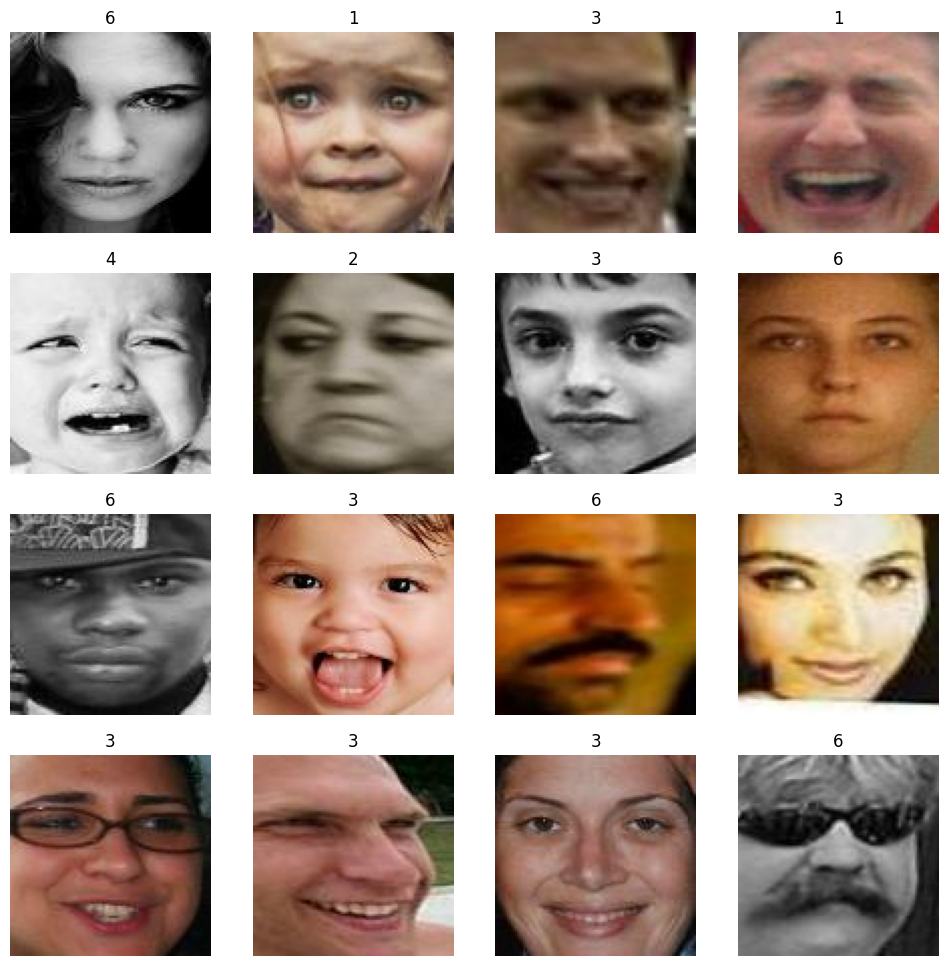

In [7]:
plt.figure(figsize=(12, 12))
for imgs, labels in train_dataset.take(2):
    for i in range(16):
        ax = plt.subplot(4,4,i+1)
        plt.imshow(imgs[i]/255)
        plt.title(np.argmax(labels[i], axis=0))
        plt.axis('off')
        

In [8]:
train_dataset = (train_dataset.prefetch(tf.data.AUTOTUNE))
test_dataset = (test_dataset.prefetch(tf.data.AUTOTUNE))

In [52]:
model = models.Sequential([
    layers.InputLayer(input_shape=(100, 100, 3)),
    layers.Rescaling(1./255, name="rescaling"),
    layers.Conv2D(filters=32, kernel_size=3, strides=(1, 1), activation='relu',
                  kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    layers.Dropout(0.3),
    layers.Conv2D(filters=64, kernel_size=3, strides=(1, 1), activation='relu',
                  kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    layers.Flatten(),
    layers.Dense(100, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(10, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(len(CLASS_NAMES), activation='softmax')
])

d:\ml\ML-webapp\.venv\lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [17]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(100, 100, 3))
base_model.trainable = True

fine_tune_at = 15

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(len(CLASS_NAMES), activation='softmax')
])

In [77]:
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy',
              metrics=['accuracy'])

In [78]:
checkpoint=ModelCheckpoint(r'./models/model2.keras',
                          monitor='val_accuracy',
                          mode='max',
                          save_best_only=True,
                          verbose=1)
earlystop=EarlyStopping(monitor='val_accuracy',
                        mode='max',
                       min_delta=0.001,
                       patience=20,
                       verbose=1,
                       restore_best_weights=True)

callbacks=[checkpoint,earlystop]

In [79]:
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 10)             │       128,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 7)              │            77 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 221,335 (864.59 KB)

 Trainable params: 221,335 (864.59 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    train_dataset, 
    validation_data=test_dataset,
    epochs=50,
    batch_size=64,
    callbacks=callbacks)

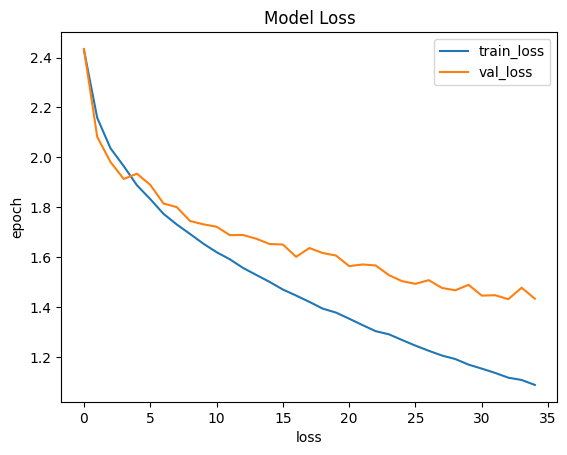

In [63]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.xlabel('loss')
plt.ylabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [22]:
pickle.dump(model, open('model7008.pkl', 'wb'))